Importing Libraries and Dataset

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import metrics
from xgboost import XGBRegressor

import warnings
warnings.filterwarnings('ignore')


In [3]:
df = pd.read_csv('boxoffice.csv',encoding='latin-1')
df.head()


,title,domestic_revenue,world_revenue,distributor,opening_revenue,opening_theaters,budget,MPAA,genres,release_days
0,Star Wars: Episode VIII - The Last Jedi,"$620,181,382","$1,332,539,889",Walt Disney Studios Motion Pictures,"$220,009,584","4,232","$317,000,000",PG-13,"Action,Adventure,Fantasy,Sci-Fi",382
1,The Fate of the Furious,"$226,008,385","$1,236,005,118",Universal Pictures,"$98,786,705","4,310","$250,000,000",PG-13,"Action,Adventure,Thriller",262
2,Wonder Woman,"$412,563,408","$821,847,012",Warner Bros.,"$103,251,471","4,165","$149,000,000",PG-13,"Action,Adventure,Fantasy,Sci-Fi,War",217
3,Guardians of the Galaxy Vol. 2,"$389,813,101","$863,756,051",Walt Disney Studios Motion Pictures,"$146,510,104","4,347","$200,000,000",PG-13,"Action,Adventure,Comedy,Sci-Fi",241
4,Beauty and the Beast,"$504,014,165","$1,263,521,126",Walt Disney Studios Motion Pictures,"$174,750,616","4,210","$160,000,000",PG,"Family,Fantasy,Musical,Romance",290


Let’s check the size of the dataset.

In [4]:
df.shape

(2694, 10)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2694 entries, 0 to 2693
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   title             2694 non-null   object
 1   domestic_revenue  2694 non-null   object
 2   world_revenue     2694 non-null   object
 3   distributor       2694 non-null   object
 4   opening_revenue   2390 non-null   object
 5   opening_theaters  2383 non-null   object
 6   budget            397 non-null    object
 7   MPAA              1225 non-null   object
 8   genres            2655 non-null   object
 9   release_days      2694 non-null   object
dtypes: object(10)
memory usage: 210.6+ KB


In [6]:
df.describe().T

,count,unique,top,freq
title,2694,2468,A Beautiful Planet,3
domestic_revenue,2694,2495,"$11,272,008",3
world_revenue,2694,2501,"$25,681,505",3
distributor,2694,248,Fathom Events,292
opening_revenue,2390,2176,"$4,696",3
opening_theaters,2383,732,1,503
budget,397,124,"$40,000,000",14
MPAA,1225,8,R,568
genres,2655,567,Documentary,351
release_days,2694,457,347,35


Data Cleaning
There are times when we need to clean the data because the raw data contains lots of noise and irregularities and we cannot train an ML model on such data. Hence, data cleaning is an important part of any machine-learning pipeline

In [7]:
# I will be predicting only
# domestic_revenue in this article.

to_remove = ['world_revenue', 'opening_revenue']
df.drop(to_remove, axis=1, inplace=True)


Let’s check what is the percentage of entries in each column that is null.

In [8]:
df.isnull().sum() * 100 / df.shape[0]

title                0.000000
domestic_revenue     0.000000
distributor          0.000000
opening_theaters    11.544172
budget              85.263549
MPAA                54.528582
genres               1.447661
release_days         0.000000
dtype: float64

In [9]:
# Handling the null value columns
df.drop('budget', axis=1, inplace=True)

for col in ['MPAA', 'genres']:
	df[col] = df[col].fillna(df[col].mode()[0])

df.dropna(inplace=True)

df.isnull().sum().sum()


0

In [10]:
df['domestic_revenue'] = df['domestic_revenue'].str[1:]

for col in ['domestic_revenue', 'opening_theaters', 'release_days']:
	df[col] = df[col].str.replace(',', '')

	# Selecting rows with no null values
	# in the columns on which we are iterating.
	temp = (~df[col].isnull())
	df[temp][col] = df[temp][col].convert_dtypes(float)

	df[col] = pd.to_numeric(df[col], errors='coerce')


Exploratory Data Analysis
EDA is an approach to analyzing the data using visual techniques. It is used to discover trends, and patterns, or to check assumptions with the help of statistical summaries and graphical representations. 

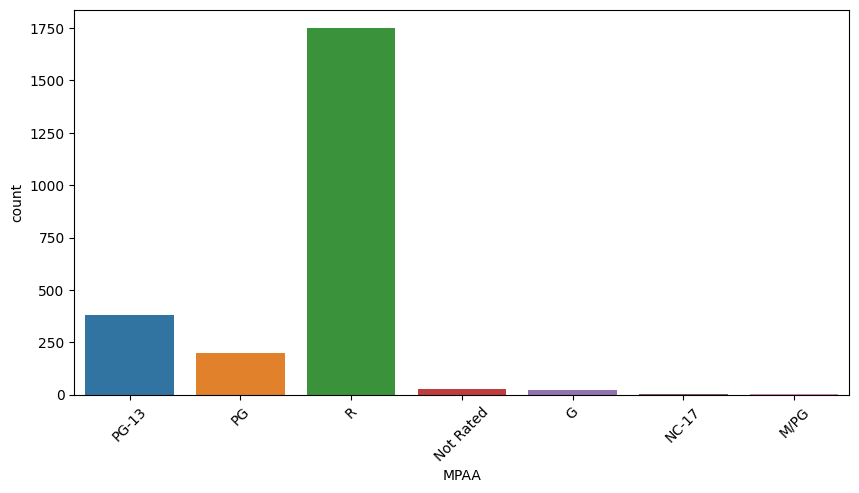

In [12]:
plt.figure(figsize=(10, 5))
# Assuming df is your DataFrame with an 'MPAA' column
sb.countplot(data=df, x='MPAA')
# Optionally, you can rotate the x-axis labels for better readability
plt.xticks(rotation=45)
plt.show()

In [14]:
# Convert 'domestic_revenue' column to numeric
df['domestic_revenue'] = pd.to_numeric(df['domestic_revenue'], errors='coerce')

# Group by 'MPAA' and calculate the mean of 'domestic_revenue'
mean_domestic_revenue_by_mpaa = df.groupby('MPAA')['domestic_revenue'].mean()

# Now you can access the mean domestic revenue for each 'MPAA' category
print(mean_domestic_revenue_by_mpaa)

MPAA
G            3.539276e+07
M/PG         5.113500e+05
NC-17        1.368800e+04
Not Rated    4.897703e+05
PG           5.379622e+07
PG-13        5.891966e+07
R            6.591336e+06
Name: domestic_revenue, dtype: float64


Here I can observe that the movies with PG or PG-13 ratings generally have their revenue higher than the other rating class.

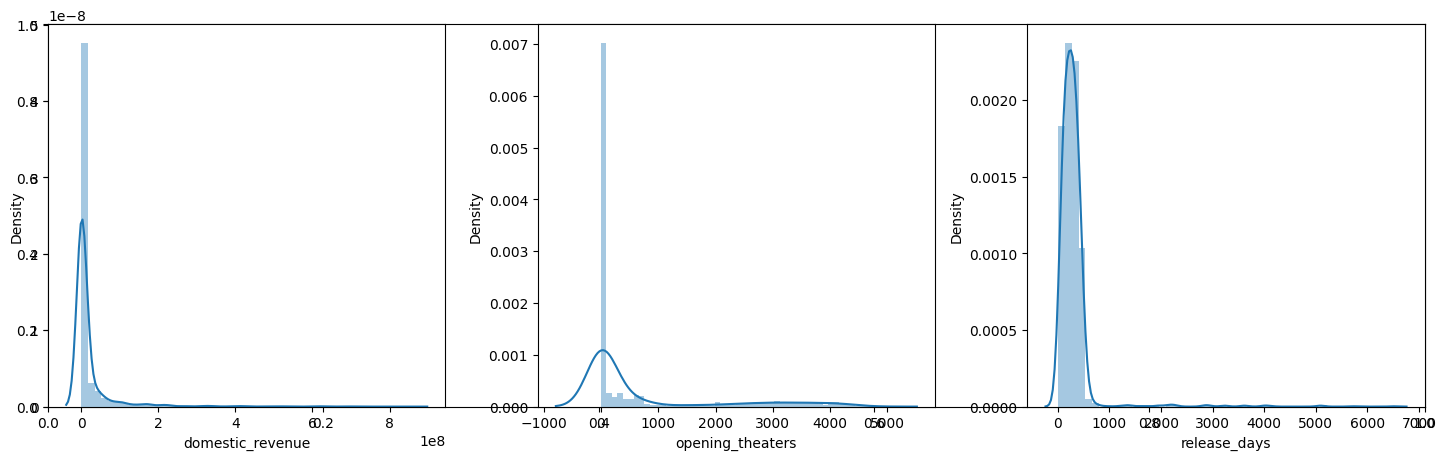

In [15]:
plt.subplots(figsize=(15, 5))

features = ['domestic_revenue', 'opening_theaters', 'release_days']
for i, col in enumerate(features):
	plt.subplot(1, 3, i+1)
	sb.distplot(df[col])
plt.tight_layout()
plt.show()


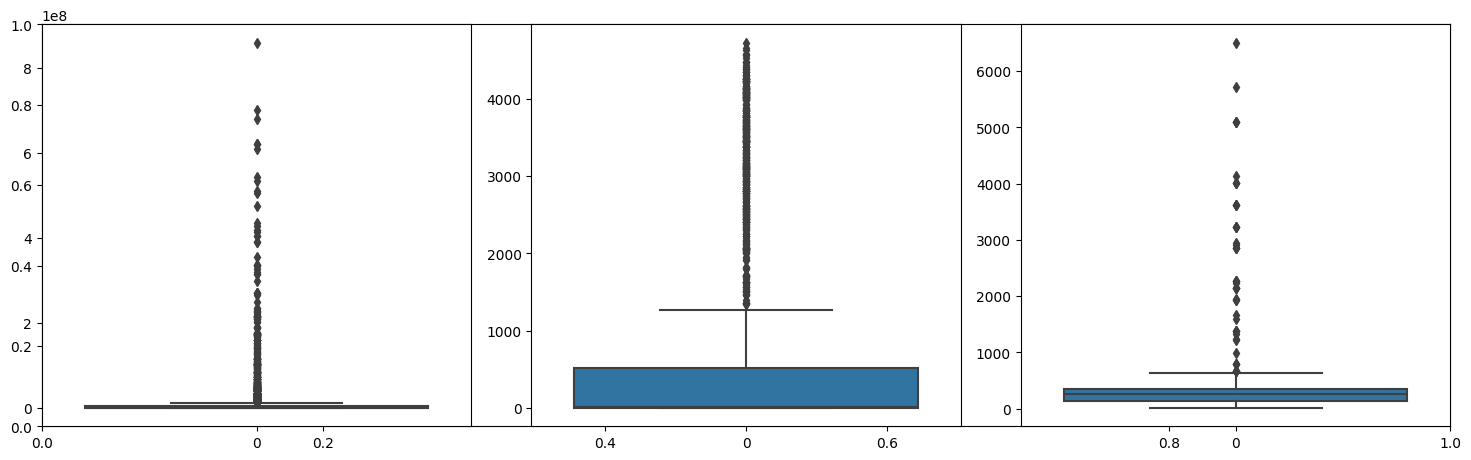

In [16]:
plt.subplots(figsize=(15, 5))
for i, col in enumerate(features):
	plt.subplot(1, 3, i+1)
	sb.boxplot(df[col])
plt.tight_layout()
plt.show()


Certainly, there are a lot of outliers in the above features.

In [18]:
for col in features:
    df[col] = df[col].apply(lambda x: np.log10(x))


Now the data in the columns i have visualized above should be close to normal distribution.

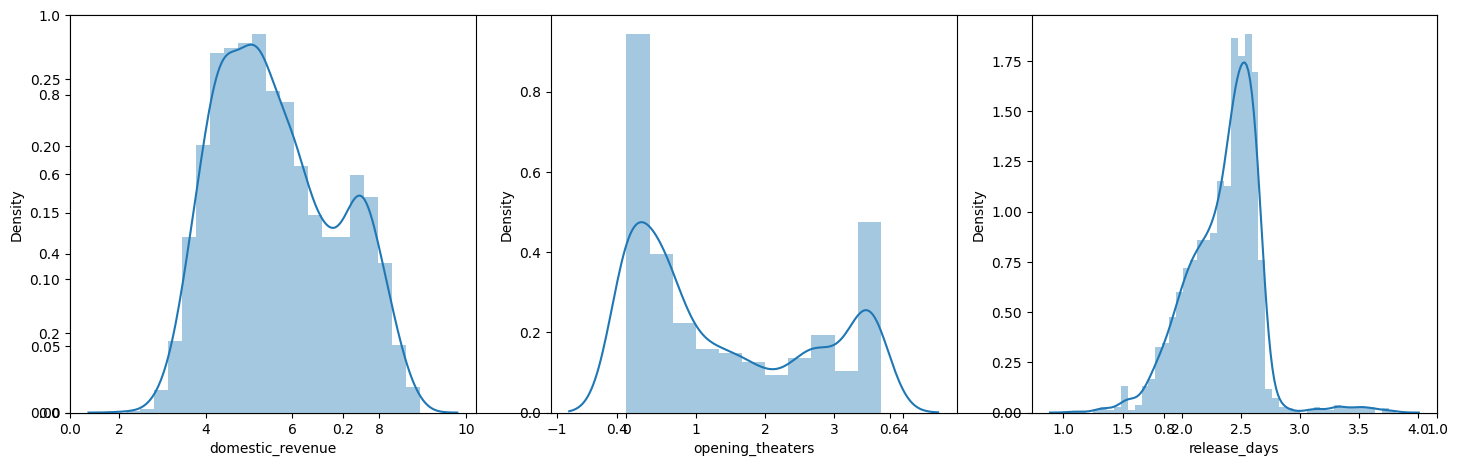

In [19]:
plt.subplots(figsize=(15, 5))
for i, col in enumerate(features):
	plt.subplot(1, 3, i+1)
	sb.distplot(df[col])
plt.tight_layout()
plt.show()


Creating Features from the Genre

In [21]:
# Create a CountVectorizer
vectorizer = CountVectorizer()
vectorizer.fit(df['genres'])

# Transform the 'genres' column and get the feature names
features = vectorizer.transform(df['genres']).toarray()
genres = vectorizer.get_feature_names_out()

# Iterate through the feature names and add them to the DataFrame
for i, name in enumerate(genres):
    df[name] = features[:, i]

# Drop the original 'genres' column
df.drop('genres', axis=1, inplace=True)


But there will be certain genres that are not that frequent which will lead to increases in the complexity of the model unnecessarily. So, i will remove those genres which are very rare.

In [22]:
removed = 0
for col in df.loc[:, 'action':'western'].columns:

	# Removing columns having more
	# than 95% of the values as zero.
	if (df[col] == 0).mean() > 0.95:
		removed += 1
		df.drop(col, axis=1, inplace=True)

print(removed)
print(df.shape)


11
(2383, 24)


In [23]:
for col in ['distributor', 'MPAA']:
	le = LabelEncoder()
	df[col] = le.fit_transform(df[col])


As all the categorical features have been labeled encoded let’s check if there are highly correlated features in the dataset.

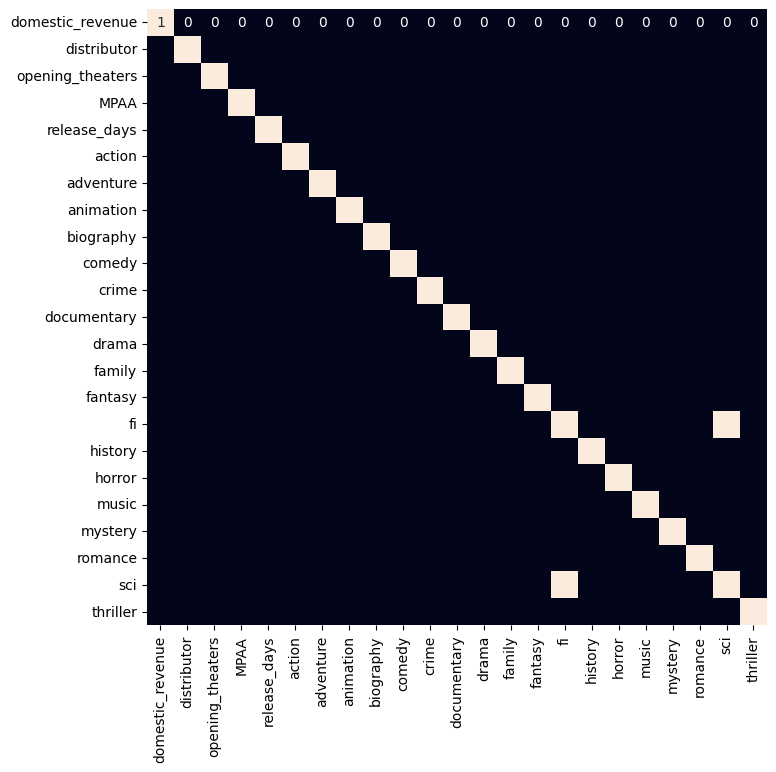

In [26]:
import seaborn as sns
# Select only numeric columns in your DataFrame
numeric_df = df.select_dtypes(include='number')

# Create a correlation matrix for the numeric columns
correlation_matrix = numeric_df.corr()

# Create a heatmap
plt.figure(figsize=(8, 8))
sns.heatmap(correlation_matrix > 0.8, annot=True, cbar=False)
plt.show()

Model Development
Now we will separate the features and target variables and split them into training and the testing data by using which we will select the model which is performing best on the validation data.

In [27]:
features = df.drop(['title', 'domestic_revenue', 'fi'], axis=1)
target = df['domestic_revenue'].values

X_train, X_val,\
	Y_train, Y_val = train_test_split(features, target,
									test_size=0.1,
									random_state=22)
X_train.shape, X_val.shape


((2144, 21), (239, 21))

In [28]:
# Normalizing the features for stable and fast training.
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)


XGBoost library models help to achieve state-of-the-art results most of the time so, we will also train this model to get better results.

In [36]:
from sklearn.metrics import mean_absolute_error as mae
model = XGBRegressor()
model.fit(X_train, Y_train)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [38]:
train_preds = model.predict(X_train)
print('Training Error : ', mae(Y_train, train_preds))

val_preds = model.predict(X_val)
print('Validation Error : ', mae(Y_val, val_preds))
print()

Training Error :  0.1311083568380254
Validation Error :  0.4340367343796249



This mean absolute error value we are looking at is between the logarithm of the predicted values and the actual values.